#**This notebook Train and evaluate the models after the preproccesing.**

# Install Required Libraries


In [50]:
pip install --upgrade scikit-learn matplotlib


# Library Imports and Setup
- Import necessary libraries
- Define the device (GPU/CPU) for computations.

In [22]:
import torch
import pickle
import numpy as np
import time
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))


Using device: cpu


# CIFAR-10 Data Loading and Filtering
- Load CIFAR-10 dataset using PyTorch's `torchvision.datasets`.
- Preprocess:
  - Resize images to 224x224.
  - Normalize pixel values using CIFAR-10 mean and standard deviation.
- Filter to 500 training and 100 test images per class for balanced sampling.
- Dimensionality Reduction
- Filtered Sampling
- Return processed data for training and evaluation.



In [23]:
def preprocess_dataset():
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load CIFAR-10 Dataset
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    # Filter dataset (500 train, 100 test images per class)
    train_data_by_class = {i: [] for i in range(10)}
    test_data_by_class = {i: [] for i in range(10)}
    for img, label in train_dataset:
        if len(train_data_by_class[label]) < 500:
            train_data_by_class[label].append((img, label))
    for img, label in test_dataset:
        if len(test_data_by_class[label]) < 100:
            test_data_by_class[label].append((img, label))

    # Extract features using ResNet-18
    resnet = resnet18(weights="IMAGENET1K_V1").to(device)
    resnet = nn.Sequential(*list(resnet.children())[:-1])

    def extract_features(data_by_class):
        features, labels = [], []
        with torch.no_grad():
            for class_images in data_by_class.values():
                for img, label in class_images:
                    img = img.unsqueeze(0).to(device)
                    feature = resnet(img).squeeze().cpu().numpy()
                    features.append(feature)
                    labels.append(label)
        return np.array(features), np.array(labels)

    train_features, y_train = extract_features(train_data_by_class)
    test_features, y_test = extract_features(test_data_by_class)

    # Normalize and apply PCA
    train_mean, train_std = train_features.mean(axis=0), train_features.std(axis=0)
    train_features = (train_features - train_mean) / train_std
    test_features = (test_features - train_mean) / train_std

    pca = PCA(n_components=50, random_state=42)
    reduced_train_features = pca.fit_transform(train_features)
    reduced_test_features = pca.transform(test_features)

    return reduced_train_features, reduced_test_features, y_train, y_test

# Preprocess the dataset
reduced_train_features, reduced_test_features, y_train, y_test = preprocess_dataset()


Files already downloaded and verified
Files already downloaded and verified


#Scikit-learn Decision Tree Implementation
- Model Initialization
- Training, Prediction, Evaluation, and Model Saving

In [60]:
# Scikit-learn Decision Tree
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)

# Train the model
start_time = time.time()
dt_classifier.fit(reduced_train_features, y_train)
train_time = time.time() - start_time

# Predict on test set
start_time = time.time()
y_pred_sklearn_dt = dt_classifier.predict(reduced_test_features)
predict_time = time.time() - start_time

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_sklearn_dt)
print(f"Accuracy: {accuracy_dt:.2f}, Training Time: {train_time:.2f}s, Prediction Time: {predict_time:.2f}s")

# # Save the Scikit-learn Decision Tree model
# with open("/content/drive/MyDrive/Untitled folder/sklearn_decision_tree.pkl", 'wb') as f:
#     pickle.dump(dt_classifier, f)
# print("Scikit-learn Decision Tree model saved.")


Accuracy: 0.22, Training Time: 0.53s, Prediction Time: 0.00s
Scikit-learn Decision Tree model saved.


#Manual Decision Tree Implementation
- Build and train a Decision Tree with Gini-based splits and stopping conditions.


In [55]:
class ManualDecisionTree:
    def __init__(self, max_depth=50):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(set(y)) == 1:
            return self._create_leaf(y)
        best_split = self._find_best_split(X, y)
        if not best_split:
            return self._create_leaf(y)
        left_idx = best_split['left_idx']
        right_idx = best_split['right_idx']
        left_tree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_tree = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return {'feature': best_split['feature'], 'threshold': best_split['threshold'], 'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_gini = float('inf')
        best_split = None
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_idx = np.where(X[:, feature_idx] <= threshold)[0]
                right_idx = np.where(X[:, feature_idx] > threshold)[0]
                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue
                gini = self._calculate_gini(y[left_idx], y[right_idx])
                if gini < best_gini:
                    best_gini = gini
                    best_split = {'feature': feature_idx, 'threshold': threshold, 'left_idx': left_idx, 'right_idx': right_idx}
        return best_split

    def _calculate_gini(self, left_y, right_y):
        def gini(y):
            classes, counts = np.unique(y, return_counts=True)
            probabilities = counts / len(y)
            return 1 - np.sum(probabilities ** 2)
        n = len(left_y) + len(right_y)
        gini_left = gini(left_y) * (len(left_y) / n)
        gini_right = gini(right_y) * (len(right_y) / n)
        return gini_left + gini_right

    def _create_leaf(self, y):
        classes, counts = np.unique(y, return_counts=True)
        return classes[np.argmax(counts)]

    def _traverse_tree(self, x, tree):
        if isinstance(tree, dict):
            if x[tree['feature']] <= tree['threshold']:
                return self._traverse_tree(x, tree['left'])
            else:
                return self._traverse_tree(x, tree['right'])
        else:
            return tree

# Train the Manual Decision Tree
manual_dt = ManualDecisionTree(max_depth=50)
manual_dt.fit(reduced_train_features, y_train)


Manual Decision Tree model saved.


# Training and Evaluation for the next two cells
- Evaluate models
- Measure and display training times for both implementations.
- Display classification report and confusion matrix heatmap.
- Save the model as a .pkl file.

In [59]:
manual_dt = ManualDecisionTree(max_depth=50)

# Train the Manual Decision Tree
start_time = time.time()
manual_dt.fit(reduced_train_features, y_train)
training_time_manual = time.time() - start_time

# Predict on the test set
start_time = time.time()
y_pred_manual_dt = manual_dt.predict(reduced_test_features)
predict_time_manual = time.time() - start_time

# Evaluate Manual Decision Tree
print(f"Manual Decision Tree Accuracy: {accuracy_score(y_test, y_pred_manual_dt):.2f}")
print(f"Training Time: {training_time_manual:.2f}s, Prediction Time: {predict_time_manual:.2f}s")

# # Save the Manual Decision Tree model using pickle
# with open("/content/drive/MyDrive/Untitled folder/manual_decision_tree.pkl",'wb') as f:
#     pickle.dump(manual_dt, f)
# print("Manual Decision Tree model saved as 'manual_decision_tree.pkl'.")




Manual Decision Tree Accuracy: 0.20
Training Time: 340.68s, Prediction Time: 0.01s
Manual Decision Tree model saved as 'manual_decision_tree.pkl'.


Manual Decision Tree Accuracy: 0.22
Manual Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.21      0.19       100
           1       0.28      0.34      0.31       100
           2       0.28      0.26      0.27       100
           3       0.09      0.11      0.10       100
           4       0.19      0.18      0.19       100
           5       0.23      0.16      0.19       100
           6       0.24      0.36      0.29       100
           7       0.21      0.18      0.19       100
           8       0.29      0.18      0.22       100
           9       0.29      0.26      0.27       100

    accuracy                           0.22      1000
   macro avg       0.23      0.22      0.22      1000
weighted avg       0.23      0.22      0.22      1000



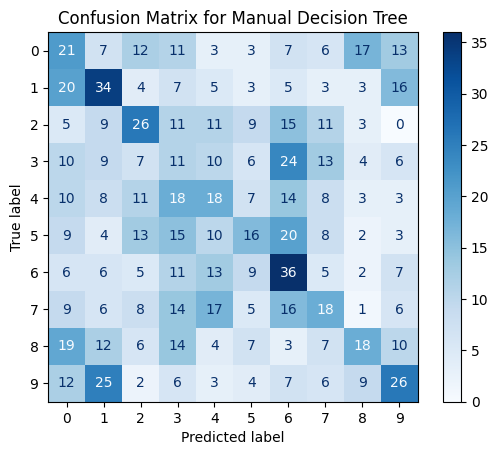

Scikit-learn Decision Tree Accuracy: 0.22
Scikit-learn Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.23      0.21       100
           1       0.30      0.36      0.33       100
           2       0.26      0.25      0.26       100
           3       0.09      0.10      0.09       100
           4       0.18      0.16      0.17       100
           5       0.21      0.15      0.18       100
           6       0.23      0.35      0.28       100
           7       0.25      0.21      0.23       100
           8       0.28      0.18      0.22       100
           9       0.28      0.25      0.26       100

    accuracy                           0.22      1000
   macro avg       0.23      0.22      0.22      1000
weighted avg       0.23      0.22      0.22      1000



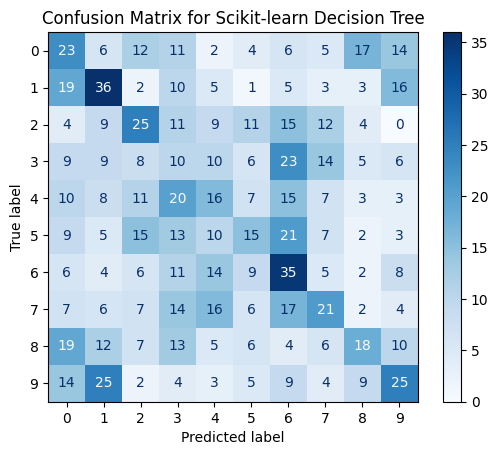

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define evaluation function
def evaluate_model(y_true, y_pred, title="Model Evaluation"):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{title} Accuracy: {accuracy:.2f}")

    # Classification report
    print(f"{title} Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Evaluate Manual Decision Tree
evaluate_model(y_test, y_pred_manual_dt, title="Manual Decision Tree")

# Evaluate Scikit-learn Decision Tree
evaluate_model(y_test, y_pred_sklearn_dt, title="Scikit-learn Decision Tree")


#Visualization
Compare training and prediction times for Manual and Scikit-learn Decision Trees using a bar chart:
- Blue bars: Training times.
- Orange bars: Prediction times.

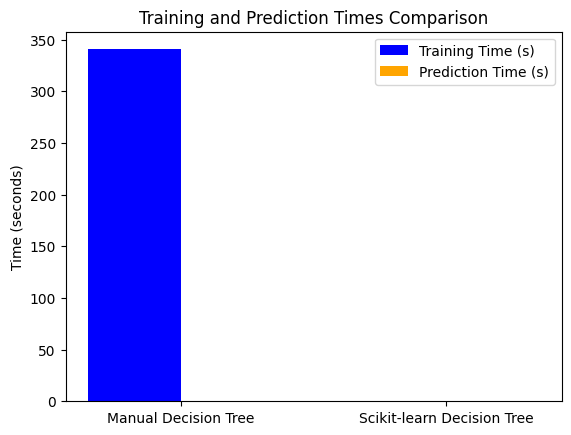

In [61]:
methods = ["Manual Decision Tree", "Scikit-learn Decision Tree"]
training_times = [training_time_manual, train_time]
prediction_times = [predict_time_manual, predict_time]

bar_width = 0.35
x = np.arange(len(methods))

plt.bar(x - bar_width/2, training_times, bar_width, label="Training Time (s)", color="blue")
plt.bar(x + bar_width/2, prediction_times, bar_width, label="Prediction Time (s)", color="orange")

plt.xticks(x, methods)
plt.ylabel("Time (seconds)")
plt.title("Training and Prediction Times Comparison")
plt.legend()
plt.show()
